# **ЗАДАНИЕ 5. ПОСТРОЕНИЕ ТРЕНД-СЕЗОННЫХ МОДЕЛЕЙ (МОДЕЛИРОВАНИЕ СЕЗОННЫХ КОЛЕБАНИЙ(здесь рассматривается классическое))**
Постройте тренд-сезонную модель, описывающую ряд данных по ценам на материал 2. Рассчитайте показатели точности и адекватности построенной модели. Дайте точечный и интервальный прогнозы на 1 год вперёд по построенной модели.
Постарайтесь максимально автоматизировать все вычисления, использовать существующие модули среды программирования Python.

In [ ]:
!pip install --upgrade xlrd

     |████████████████████████████████| 96 kB 1.9 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import linregress
from math import sqrt
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from pandas.plotting import autocorrelation_plot
import scipy.stats
import seaborn as sns
from scipy.stats import t as student
from pandas import Grouper
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**1.	Прочитайте данные по ценам на материал 2 и приведите их к виду, пригодному для дальнейшего анализа (см. пп.1-10 Задания 1).**

In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/PDA-210')

In [ ]:
data=pd.read_excel('data.xls', sheet_name='Material 2')
data.head()

,Unnamed: 0,Unnamed: 1,Рыночные цены на материал 2 (руб.),Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,NaN,NaN,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,...,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00
1,№ организации,1.0,4.22,3.99,4.05,4.34,4.63,4.76,5.09,5.13,...,3.81,4.03,4.13,4.4,4.66,4.79,4.57,4.4,4.26,3.82
2,NaN,2.0,4,4.14,4.43,4.79,5.1,5.17,5.12,4.89,...,4.87,5.19,5.29,5.46,5.45,5.15,4.94,4.6,4.41,4.35
3,NaN,3.0,3.9,3.74,3.9,4.13,4.31,4.66,4.76,4.85,...,4.23,4.48,4.71,5.05,5.21,5.21,5.19,5.08,4.77,4.53
4,NaN,4.0,3.64,3.94,4.09,4.73,5,5.46,5.46,5.41,...,4.23,4.55,5.1,5.41,5.62,5.36,5.05,4.54,4.24,3.83


In [ ]:
df = data.iloc[0:2,2:].T.rename(columns={0: 'Date', 1: 'Value'}).set_index('Date')
df.dtypes
#iloc[0:2,2:]                             - нарезал нужные строки и столбцы
#.T                                       - поверхул всё, т.е. транспонировал
#.rename(columns={0: 'Date', 1: 'Value'}) - поменял названия столбцов
# .set_index('Date')                      - сделал столбец с датами индексом

Value    object
dtype: object

In [ ]:
df['Value'] = df['Value'].astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2007-01-01 to 2010-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [ ]:
df.sample(4)

,Value
Date,
2009-09-01,4.88
2008-04-01,4.28
2009-01-01,3.96
2007-08-01,5.13


**2.	Убедитесь в том, что Вы работаете с объектом Series, а не DataFrame. Превратить таблицу с одним столбцом целевых значений в объект Series можно с помощью функции squeeze(). Дайте ему название series.**

In [ ]:
series=df.squeeze()
type(series)

pandas.core.series.Series

**3.	Посмотрите на динамику временного ряда и его положение относительно линейного тренда визуально с помощью функции regplot(x=x, y=y, data= data) из модуля seaborn. В качестве x возьмите номера наблюдений, а y – значения цены на материал 2. Прокомментируйте результат. Обратите внимание на амплитуду колебаний.**

In [ ]:
y=series.values

In [ ]:
t=np.arange(1,len(y)+1)
t

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

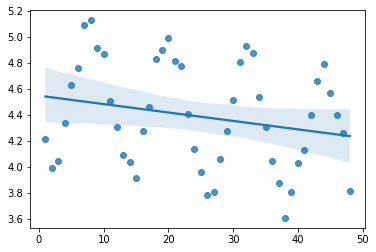

In [ ]:
sns.regplot(x=t, y=y, data= df) # мы видим сезонные колебания - колебания в пределах года
                                # есть спадающий(нисходящий) тренд

In [ ]:
# окончательная модель = трендовая составляющая + сезонная составляющая + случайная составляющая

**лаг сезонности** - промежуток времени между двумя пиковыми значениями

**4.	Определите лаг сезонности с помощью коррелограммы. Воспользуйтесь функцией autocorrelation_plot() из модуля pandas.plotting. Запишите предполагаемое число.**

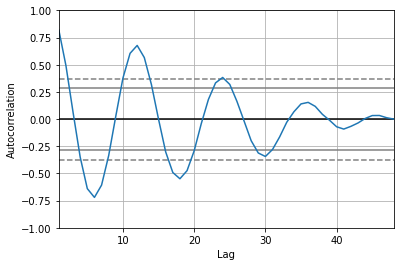

In [ ]:
autocorrelation_plot(y)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (18, 6)) # лаг сезонности похоже = 12

autocorrelation_plot(y, ax = ax, marker = '.')
ax.xaxis.set_major_locator(plt.MultipleLocator(6))
ax.set_xlim(0, 48)

plt.show()

**5.	Разделите исходные данные на обучающий набор (36 наблюдений) и тестовый набор (12 наблюдений). Для этого создайте переменную y, в которую запишите значения временного ряда, обратившись к параметру values. Затем создайте переменную y_train, содержащую обучающую выборку и переменную y_test, содержащую тестовый набор. Выведите на экран объем обучающей и тестовой выборки.**

In [ ]:
train_size=36

In [ ]:
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [ ]:
len(y_train)

36

In [ ]:
len(y_test)

12

**6.	Запишите в переменную series_train объект Series, содержащий тестовую выборку. Для этого нужно взять срез объекта series. Выведите на экран первые 5 наблюдений.**

In [ ]:
series_train = series[0:train_size]
series_train.head()

Date
2007-01-01    4.22
2007-02-01    3.99
2007-03-01    4.05
2007-04-01    4.34
2007-05-01    4.63
Name: Value, dtype: float64

# **Начинаем строить модель сезонных колебаний !!!!! :**

1. Оценивается сезонная составляющая с учетом характера сезонности

2. Сезонная составляющая убирается из исходных данных

3. Оценивается тренд

4. Собираются в единую модель тендовая и сезонная составляющие, оценивается адекватность этой модели

5. Использование данной модели для прогнозирования

# **1.**

1.1 Сглаживаем временной ряд (с помощью скользящей средней)

1.2 Из исходного ряда исключаем выровненный ряд(отражает эффект сезонности и случайности), т.е.из исходного ряда исключается сезонная составвляющаая и случайная

**7.	Проведите сглаживание временного ряда, записанного в переменной series_train, с помощью процедуры скользящей средней для предварительного оценивания тенденции развития. Воспользуйтесь последовательностью функций rolling().mean(). Ширину окна возьмите равной лагу сезонности. Результат запишите в переменную rolling_mean. Выведите на экран первые 20 наблюдений.**

**1.СГЛАЖИВАЕМ :**

In [ ]:
# т.е. после сглаживания мы получаем тренд, Т.Е.  rolling_mean - это тренд

In [ ]:
rolling_mean=series_train.rolling(window=12).mean() # окно=12, т.к. лаг сезонности = 12
rolling_mean.head(20)

Date
2007-01-01         NaN
2007-02-01         NaN
2007-03-01         NaN
2007-04-01         NaN
2007-05-01         NaN
2007-06-01         NaN
2007-07-01         NaN
2007-08-01         NaN
2007-09-01         NaN
2007-10-01         NaN
2007-11-01         NaN
2007-12-01    4.568333
2008-01-01    4.557500
2008-02-01    4.561667
2008-03-01    4.550833
2008-04-01    4.545833
2008-05-01    4.531667
2008-06-01    4.537500
2008-07-01    4.521667
2008-08-01    4.510000
Name: Value, dtype: float64

**8.	Постройте диаграмму, на которую поместите исходные данные и сглаженный ряд, нарисованный красным цветом. Воспользуйтесь функцией plot() для исходного и сглаженного ряда, а также функцией show() из модуля matplotlib.pyplot.**

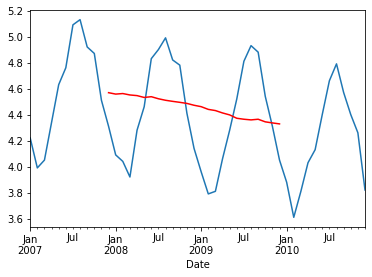

In [ ]:
series.plot()
rolling_mean.plot(color='red') # первых нет потому что окно =12, выпадают, а последних нет, т.к. они ушли в тестовый набор
plt.show()

**2. ИЗ СИНЕГО РЯДА ВЫЧТЕМ КРАСНЫЙ и получим сезонную составляющую и случайную составляющую :**

**9. Рассчитайте уровни ряда x_t, которые отражают эффект сезонности и случайности. Результат запишите в переменную X. Выведите на экран первые 20 наблюдений.**

In [ ]:
X=y_train-rolling_mean # СОДЕРЖИТ СЕЗОННОСТЬ И СЛУЧАЙНОСТЬ
X.head(20)

Date
2007-01-01         NaN
2007-02-01         NaN
2007-03-01         NaN
2007-04-01         NaN
2007-05-01         NaN
2007-06-01         NaN
2007-07-01         NaN
2007-08-01         NaN
2007-09-01         NaN
2007-10-01         NaN
2007-11-01         NaN
2007-12-01   -0.258333
2008-01-01   -0.467500
2008-02-01   -0.521667
2008-03-01   -0.630833
2008-04-01   -0.265833
2008-05-01   -0.071667
2008-06-01    0.292500
2008-07-01    0.378333
2008-08-01    0.480000
Name: Value, dtype: float64

In [ ]:
X.shape

(36,)

**3. ЧИСТИМ ОТ СЛУЧАЙНЫХ ЗНАЧЕНИЙ, очищаем сезонную составляющую**

**10.	 Для элиминирования влияния случайных факторов определите предварительные значения сезонной составляющей, как средние значения из уровней x_t для одноименных месяцев. Результаты представьте в виде таблицы, где в строках представлены данные за одноименный месяц по 3-м годам. Это потребует выполнения следующих действий:**

**10.1	Импортируйте функции DataFrame и Grouper из модуля pandas.**

**10.2	Сгруппируйте временной ряд x_t, полученный в п.9, по годам с помощью функции groupby(Grouper(freq='A')) и поместите результат в переменную groups.**

**10.3	Создайте пустую таблицу данных с помощью функции DataFrame() и поместите результат в переменную years.**

**10.4	С помощью команды for, перебирая период (name) и данные (group), содержащиеся в переменной groups, создайте в таблице данных years столбцы для каждого года (name.year), заполненные соответствующими данными ряда x_t (group.values).**

**10.5	Создайте в таблице данных years столбец mean, содержащий среднее арифметическое сезонных коэффициентов (x ̅_i). Для этого примените к таблице years функцию mean(axis=1).**


In [ ]:
groups=X.groupby(Grouper(freq='A'))

In [ ]:
years=pd.DataFrame()

""


In [ ]:
for name, group in groups:
  years[name.year]=group.values

In [ ]:
for i, j in groups:
  years[i.year]=j.values

In [ ]:
years['mean']=years.mean(axis=1) # делает столбец в который выводится среднее в строке, т.е. за 3 года
years.shape

(12, 4)

**11. Рассчитайте среднее значение по столбцу mean, воспользовавшись функцией mean(). Запишите содержимое в переменную k. Выведите ее значение на экран.**

In [ ]:
k=years['mean'].mean() # среднее по столбцу 'mean', т.к. среднее отличается от 0, то и сумма отличается
                       # от 0, а значит нужно вносить поправки
k

-0.0520023148148149

**12	Проведите корректировку первоначальных значений сезонной составляющей, вызванную тем, что суммарное воздействие сезонности на динамику предполагается нейтральным. Окончательные оценки коэффициентов сезонности S_i находятся по следующей формуле:**

**12.1	В случае аддитивной тренд-сезонной модели: S_i=x ̅_i-k (i= 1,2,…,m); k=1/m ∑_(t=1)^m▒x ̅_i ;**

**12.2	В случае мультипликативной тренд-сезонной модели: S_i= x ̅_i k (i= 1,2,…,m); k=m/(∑_(i=1)^m▒x ̅_i ), **
**где m – число фаз в полном сезонном цикле (m =12 для рядов месячной динамики).**
**Запишите найденные оценки коэффициентов сезонности S_i в столбец 'S' таблицы years. Выведите содержимое таблицы на экран.**


**4. В СТОЛБЦЕ 'S' НАХОДИТСЯ ОЧИЩЕННАЯ СЕЗОННАЯ СОСТАВЛЯЮЩАЯ**

In [ ]:
years['S']=years['mean']-k # проводим корректировку, т.е. создаем столбец с корректированными данными
years

,2007,2008,2009,mean,S
0,NaN,-0.467500,-0.500833,-0.484167,-0.432164
1,NaN,-0.521667,-0.650000,-0.585833,-0.533831
2,NaN,-0.630833,-0.620833,-0.625833,-0.573831
3,NaN,-0.265833,-0.352500,-0.309167,-0.257164
4,NaN,-0.071667,-0.117500,-0.094583,-0.042581
5,NaN,0.292500,0.148333,0.220417,0.272419
6,NaN,0.378333,0.445833,0.412083,0.464086
7,NaN,0.480000,0.570833,0.525417,0.577419
8,NaN,0.318333,0.515833,0.417083,0.469086
9,NaN,0.285833,0.195833,0.240833,0.292836


**5. Т.К. У НАС ЗАНЧЕНИЙ 'S' 12 ШТУК В СТОЛБЦЕ, А НАДО 36, ТО ПОВТОРЯЕМ СТОЛБЕЦ 3 РАЗА**

**13.	 Запишите содержимое столбца 'S' таблицы years в переменную s.**

In [ ]:
s=years['S']

**14.	Повторите 3 раза содержимое переменной s с помощью метода спискового включения: [s for i in range(3)]. Далее создайте временной ряд сезонных коэффициентов, соединив созданные списки в объект Series с помощью функции concat([s for i in range(3)], ignore_index = True). Результат запишите в переменную sez.**

**15.	Индекс объекта sez сделайте таким же, как и у ряда series_train. Для этого достаточно обратиться к параметру index этих временных рядов. Выведите на экран первые 5 наблюдений.**

In [ ]:
sez=pd.concat([s for i in range(3)], ignore_index = True) # т.е. получилиряд с сезонными составляющими
sez.index=series_train.index
sez.head()

Date
2007-01-01   -0.432164
2007-02-01   -0.533831
2007-03-01   -0.573831
2007-04-01   -0.257164
2007-05-01   -0.042581
Name: S, dtype: float64

**16. Проведите десезонализацию (сезонную корректировку) исходных данных по следующей формуле:**

**16.1	В случае аддитивной тренд-сезонной модели: y ̀_i=y_i-S_i;**

**16.2	В случае мультипликативной тренд-сезонной модели: y ̀_i=y_i/S_i .**

**Рассчитанное значение временного ряда y ̀_i запишите в переменную y_des. Выведите на экран первые 5 наблюдений.**


In [ ]:
#  ВЫЧИТАЕМ ИЗ ТРЕНИРОВОЧНОГО НАБОРА (36ШТ.) - СЕЗОННУЮ СОСТАВЛЯЮЩУЮ = ТРЕНД+СТУЧАЙНАЯ СОСТАВЛЯЮЩАЯ

**y_des** - это ряд по котрому можно строить модель сезонных колебаний

In [ ]:
y_des=y_train-sez
y_des.head()

Date
2007-01-01    4.652164
2007-02-01    4.523831
2007-03-01    4.623831
2007-04-01    4.597164
2007-05-01    4.672581
Name: S, dtype: float64

**17.	 Запишите в переменную t_train номера наблюдений обучающего набора. Это первые 36 наблюдений. Сгенерировать номера наблюдений можно с помощью функции arange из модуля numpy. Выведите их на экран.**

In [ ]:
x_train = np.arange(1, len(y_des)+1)
x_train

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

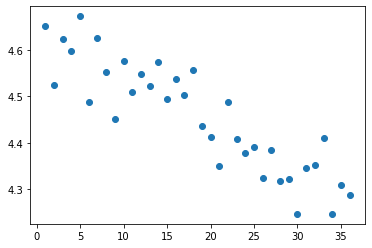

In [ ]:
plt.scatter(x_train,y_des)
plt.show()

**18. Рассчитайте значения параметров тренда (а_0,а_1) на основе временного ряда, полученного в п.16 (для значений y ̀_i). При этом вы можете воспользоваться любым методом, обсуждаемым в задании 4. Например, функцией polyfit(t_train, y_des, deg = 1) из модуля numpy. Результат запишите в переменную coef. Здесь coef[0] – коэффициент при переменой, coef[1] – свободный член. Выведите на экран полученный результат.**

In [ ]:
coef=np.polyfit(x_train, y_des, deg=1)
coef

array([-0.01000252,  4.64115774])

**РАЗЪЯСНЕНИЕ:** значения coef - это значения свободных членов для уравнения прямой

**у = -0.01000252 * х + 4.64115774**

**19.	 Запишите в переменную t_test номера наблюдений тестового набора. Это наблюдения с 37 по 48. Сгенерировать номера наблюдений можно с помощью функции arange из модуля numpy. Выведите их на экран.**

In [ ]:
t_test = np.arange(len(y_train)+1, len(y)+1)
t_test

array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

**20.	Найдите расчетные значения на тестовом наборе по уравнению тренд-сезонной модели:**

**20.1	В случае аддитивной тренд-сезонной модели:**

**y ̃_t=a_0+a_1 t+S_t**

**20.2	В случае мультипликативной тренд-сезонной модели:**

**y ̃_t=(a_0+a_1 t)S_t**

**Рассчитанные значения по модели запишите в переменную y_pred.**


In [ ]:
y_pred=coef[0]*t_test+coef[1]+s # s- это сезонная составляющая, а остальные 2(тренд+случайная) уже включены, на них обучали
y_pred

0     3.838900
1     3.727231
2     3.677228
3     3.983893
4     4.188473
5     4.493471
6     4.675135
7     4.778466
8     4.660130
9     4.473877
10    4.172208
11    3.923595
Name: S, dtype: float64

**21.	Оцените точность модели на тестовой выборке на основе коэффициента детерминации, воспользовавшись функцией r2_score() из модуля sklearn.metrics. Запишите результат.**

In [ ]:
R2=r2_score(y_test, y_pred) # очень хороший результат
R2

0.9489225749837004

**22.	Оцените точность модели на тестовой выборке на основе средней квадратичной ошибки (MSE), воспользовавшись функцией mean_squared_error(y_test, y_pred) из модуля sklearn.metrics.**

In [ ]:
MSE=mean_squared_error(y_test, y_pred)
MSE

0.006643754177259028

# **КОНЕЦ, модель хорошая**

**23.	Рассчитайте прогнозные значения на тестовой выборке по базовой модели, которая в качестве прогноза выдает прошлое значение. Результат запишите в переменную y_pred.**

In [ ]:
# Прогноз по базовой модели
y_pred=y[len(y_train)-1:len(y)-1]
y_pred

array([4.05, 3.88, 3.61, 3.81, 4.03, 4.13, 4.4 , 4.66, 4.79, 4.57, 4.4 ,
       4.26])

**24.	Оцените точность базовой модели на тестовой выборке на основе средней квадратичной ошибки (MSE), воспользовавшись функцией mean_squared_error(y_test, y_pred) из модуля sklearn.metrics. Сравните результат с аналогичным показателем тренд-сезонной модели.**

In [ ]:
MSE=mean_squared_error(y_test, y_pred) # MSE базовой модели намного хуже, значит наша модель хороша
MSE

0.05400833333333335

# **Строим тренд-сезонную модель на всех данных**

**25.	Постройте на всех данных лучшую модель. Если это тренд-сезонная модель, то см. пп.7-18.**

In [ ]:
rolling_mean=series.rolling(window=12).mean()
rolling_mean.head(20)

Date
2007-01-01         NaN
2007-02-01         NaN
2007-03-01         NaN
2007-04-01         NaN
2007-05-01         NaN
2007-06-01         NaN
2007-07-01         NaN
2007-08-01         NaN
2007-09-01         NaN
2007-10-01         NaN
2007-11-01         NaN
2007-12-01    4.568333
2008-01-01    4.557500
2008-02-01    4.561667
2008-03-01    4.550833
2008-04-01    4.545833
2008-05-01    4.531667
2008-06-01    4.537500
2008-07-01    4.521667
2008-08-01    4.510000
Name: Value, dtype: float64

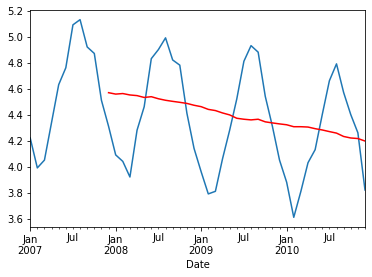

In [ ]:
series.plot()
rolling_mean.plot(color='red')
plt.show()

In [ ]:
X=y-rolling_mean
X.head(20)

Date
2007-01-01         NaN
2007-02-01         NaN
2007-03-01         NaN
2007-04-01         NaN
2007-05-01         NaN
2007-06-01         NaN
2007-07-01         NaN
2007-08-01         NaN
2007-09-01         NaN
2007-10-01         NaN
2007-11-01         NaN
2007-12-01   -0.258333
2008-01-01   -0.467500
2008-02-01   -0.521667
2008-03-01   -0.630833
2008-04-01   -0.265833
2008-05-01   -0.071667
2008-06-01    0.292500
2008-07-01    0.378333
2008-08-01    0.480000
Name: Value, dtype: float64

In [ ]:
groups=X.groupby(Grouper(freq='A'))

In [ ]:
years=pd.DataFrame()

In [ ]:
for name, group in groups:
  years[name.year]=group.values

NameError: ignored

In [ ]:
years['mean']=years.mean(axis=1)
years

,2007,2008,2009,2010,mean
0,NaN,-0.467500,-0.500833,-0.441667,-0.470000
1,NaN,-0.521667,-0.650000,-0.696667,-0.622778
2,NaN,-0.630833,-0.620833,-0.496667,-0.582778
3,NaN,-0.265833,-0.352500,-0.274167,-0.297500
4,NaN,-0.071667,-0.117500,-0.161667,-0.116944
5,NaN,0.292500,0.148333,0.118333,0.186389
6,NaN,0.378333,0.445833,0.390833,0.405000
7,NaN,0.480000,0.570833,0.532500,0.527778
8,NaN,0.318333,0.515833,0.338333,0.390833
9,NaN,0.285833,0.195833,0.180000,0.220556


In [ ]:
k=years['mean'].mean()
k

-0.05748842592592588

In [ ]:
years['S']=years['mean']-k
years

,2007,2008,2009,2010,mean,S
0,NaN,-0.467500,-0.500833,-0.441667,-0.470000,-0.412512
1,NaN,-0.521667,-0.650000,-0.696667,-0.622778,-0.565289
2,NaN,-0.630833,-0.620833,-0.496667,-0.582778,-0.525289
3,NaN,-0.265833,-0.352500,-0.274167,-0.297500,-0.240012
4,NaN,-0.071667,-0.117500,-0.161667,-0.116944,-0.059456
5,NaN,0.292500,0.148333,0.118333,0.186389,0.243877
6,NaN,0.378333,0.445833,0.390833,0.405000,0.462488
7,NaN,0.480000,0.570833,0.532500,0.527778,0.585266
8,NaN,0.318333,0.515833,0.338333,0.390833,0.448322
9,NaN,0.285833,0.195833,0.180000,0.220556,0.278044


In [ ]:
s=years['S']

In [ ]:
sez=pd.concat([s for i in range(4)], ignore_index = True)
sez.index=df.index
sez.head()

Date
2007-01-01   -0.412512
2007-02-01   -0.565289
2007-03-01   -0.525289
2007-04-01   -0.240012
2007-05-01   -0.059456
Name: S, dtype: float64

In [ ]:
y_des=y-sez
y_des.head()

Date
2007-01-01    4.632512
2007-02-01    4.555289
2007-03-01    4.575289
2007-04-01    4.580012
2007-05-01    4.689456
Name: S, dtype: float64

In [ ]:
t = np.arange(1, len(y_des)+1)
t

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [ ]:
coef=np.polyfit(t, y_des, deg=1)
coef

array([-0.0104758 ,  4.64790706])

In [ ]:
y_pred=coef[0]*t+coef[1]+sez
y_pred.head()

Date
2007-01-01    4.224920
2007-02-01    4.061666
2007-03-01    4.091190
2007-04-01    4.365992
2007-05-01    4.536072
Name: S, dtype: float64

**26.	Оцените точность модели для всех данных с помощью следующих показателей: коэффициента детерминации, MAE, MSE, RMSE. Соответствующие функции приведены в задании 4. Прокомментируйте полученные результаты.**

In [ ]:
R2=r2_score(y,y_pred)
R2

0.9804750595045576

In [ ]:
MAE=mean_absolute_error(y,y_pred) # низкий показатель, хороший
MAE

0.04641810718574251

In [ ]:
MSE=mean_squared_error(y,y_pred) # низкий показатель, хороший
MSE

0.003098089425394806

In [ ]:
RMSE=sqrt(MSE) # низкий показатель, хороший
RMSE

0.05566048351743637

**27.	Рассчитайте ошибки модели для всех данных. Поместите столбец ошибок 'Error' в таблицу исходных данных. Выведите на экран первые 5 наблюдений.**

In [ ]:
df['Error']=y-y_pred
df.head()

,Value,Error
Date,,
2007-01-01,4.22,-0.004920
2007-02-01,3.99,-0.071666
2007-03-01,4.05,-0.041190
2007-04-01,4.34,-0.025992
2007-05-01,4.63,0.093928


**28.	Постройте линейный график ошибок, воспользовавшись функциеями plot() и show() из модуля matplotlib.pyplot. Прокомментируйте результат.**

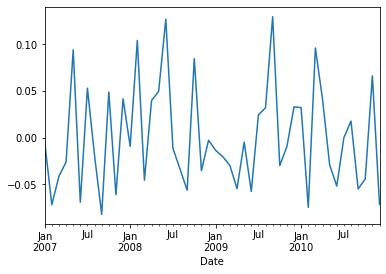

In [ ]:
df.Error.plot()
plt.show()

**29.	Выведите на экран описательные статистики ошибок, воспользовавшись функцией describe(). Прокомментируйте результат.**


In [ ]:
df.Error.describe()

count    4.800000e+01
mean     8.049117e-16
std      5.624950e-02
min     -8.194664e-02
25%     -4.441842e-02
50%     -1.046560e-02
75%      4.007208e-02
max      1.294725e-01
Name: Error, dtype: float64

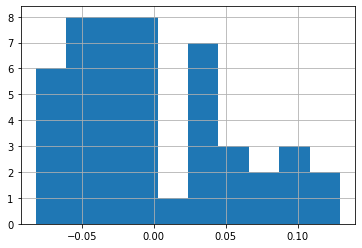

In [ ]:
df.Error.hist()
plt.show()

**30.	Постройте для ошибок гистограмму на основе функции hist(), ядерную оценку плотности на основе функции plot(kind='kde'), Q-Q график на основе функции qqplot() из модуля statsmodels.graphics.gofplots, а также функцией show() из модуля matplotlib.pyplot. Прокомментируйте результат.**

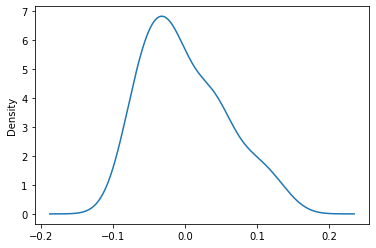

In [ ]:
df.Error.plot(kind='kde')
plt.show()

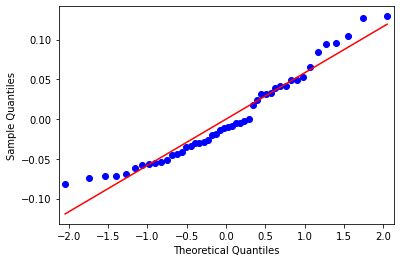

In [ ]:
qqplot(df.Error,line='r')
plt.show()

**31.	Оцените адекватность тренд-сезонной модели на основе теста Дарбина-Уотсона, воспользовавшись функцией durbin_watson() из модуля statsmodels.stats.stattools применительно к остаткам модели. Прокомментируйте результат.**

In [ ]:
d=durbin_watson(df.Error)
d

2.3863196370346564

In [ ]:
4-d

1.6136803629653436

n=48, k=1, alfa=0.05. Для n=50 и k=1, alfa=0.05 dl=1.5, du=1.59.
**4-d>du, поэтому гипотеза об отсутствии автокорреляции не отвергается.**

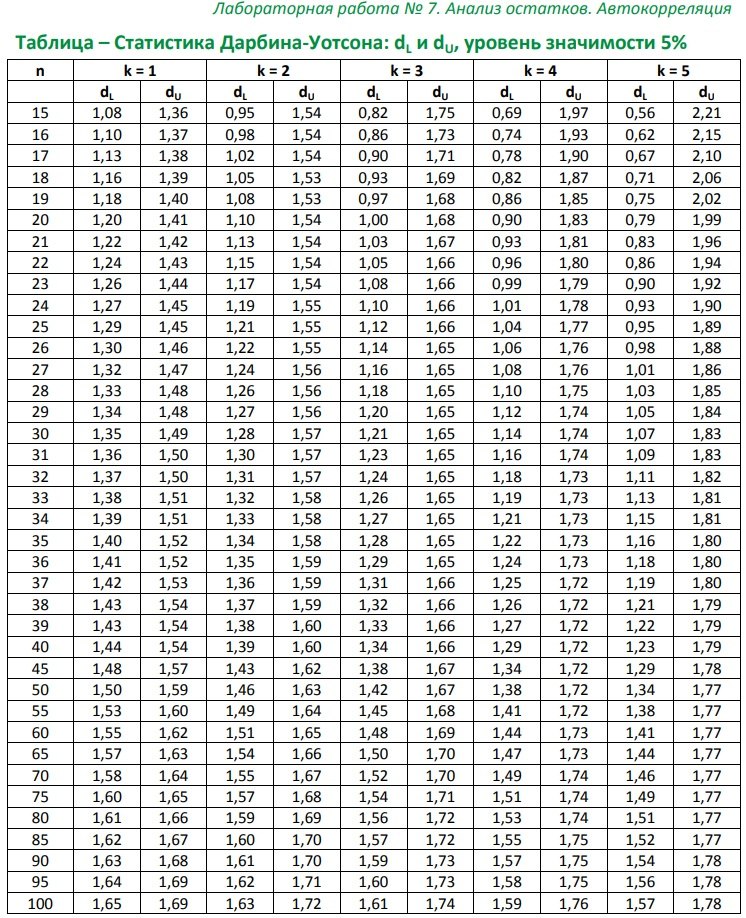

**32.	Постройте для ошибок тренд-сезонной модели коррелограмму, воспользовавшись функцией autocorrelation_plot() из модуля pandas.plotting. Прокомментируйте результат.**

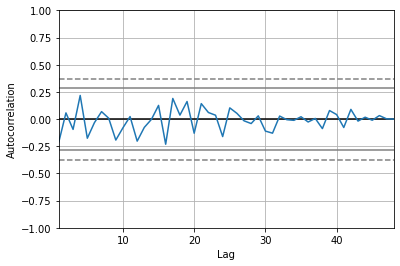

In [ ]:
autocorrelation_plot(df.Error)  # нет автокорреляции, т.к. модель в пределах границ значимости
plt.show()

**33.	На основе переменной y рассчитайте среднее квадратичное отклонение, воспользовавшись функцией sem() из модуля scipy.stats. Запишите результат в переменную sigma и выведите его на экран.**

In [ ]:
sigma =scipy.stats.sem(y)
sigma

0.058103619380434325

**34.	Рассчитайте двусторонний t критерий Стьюдента для существующего объема выборки и 95% достоверности результата (confidence). Воспользуйтесь функцией t.ppf((1 + confidence) / 2., len(y)-1) из модуля scipy.stats. Запишите результат в переменную tstu и выведите его на экран.**

In [ ]:
confidence=0.95

In [ ]:
tstu=scipy.stats.t.ppf((1 + confidence) / 2., len(y)-1)
tstu

2.0117405104757546

**35.	Сгенерируйте номера наблюдений для прогнозного интервала, равного 12 месяцев (с 49 по 60 наблюдение). Запишите результат в переменную t_new и выведите его на экран.**

In [ ]:
t_new =np.arange(len(y)+1, len(y)+13)
t_new

array([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

**36.	Найдите прогнозные значения цены на материал 2 на год вперед (точечный прогноз). Запишите результат в переменную y_new и выведите его на экран.**

In [ ]:
y_new = coef[0]*t_new+coef[1]+s
y_new

0     3.722081
1     3.558828
2     3.588352
3     3.863154
4     4.033234
5     4.326091
6     4.534227
7     4.646529
8     4.499108
9     4.318355
10    4.068157
11    3.765598
Name: S, dtype: float64

**37.	Рассчитайте верхнюю границу прогнозного интервала, воспользовавшись формулой: y_up=y_new+tstu*sigma. Выведите результат на экран.**

In [ ]:
y_up=y_new+tstu*sigma
y_up

0     3.838971
1     3.675717
2     3.705241
3     3.980043
4     4.150123
5     4.442981
6     4.651116
7     4.763418
8     4.615998
9     4.435244
10    4.185046
11    3.882487
Name: S, dtype: float64

**38.	Рассчитайте нижнюю границу прогнозного интервала, воспользовавшись формулой: y_down=y_new-tstu*sigma. Выведите результат на экран.**

In [ ]:
y_down=y_new-tstu*sigma
y_down

0     3.605192
1     3.441938
2     3.471463
3     3.746265
4     3.916344
5     4.209202
6     4.417337
7     4.529639
8     4.382219
9     4.201465
10    3.951267
11    3.648708
Name: S, dtype: float64

**39.	Нанесите на одну диаграмму фактические значения, значения по модели, точечный и интервальный прогнозы, воспользовавшись функциями figure(), scatter(), plot(), xlabel(), ylabel(), legend() и show() из модуля matplotlib.pyplot.**

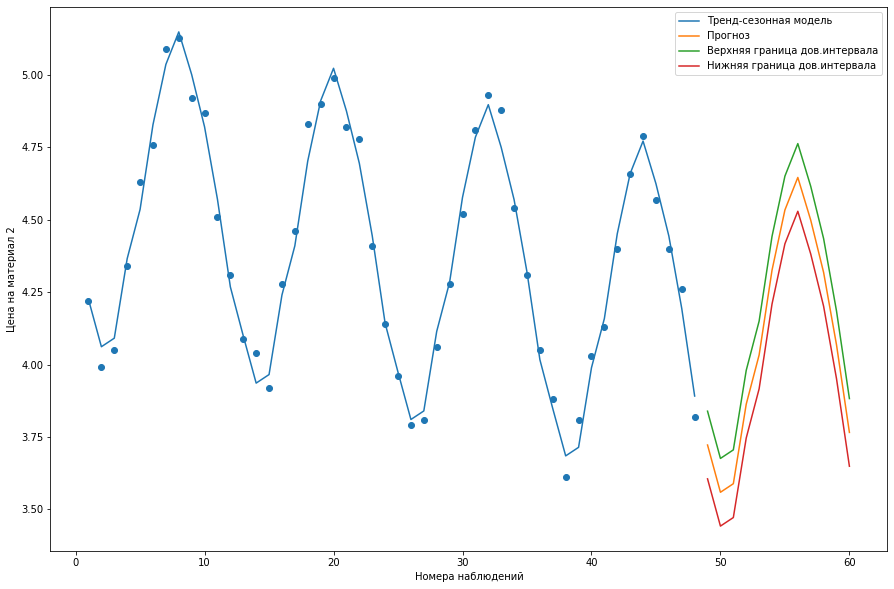

In [ ]:
plt.figure(figsize=(15,10))

plt.scatter(t,y)

plt.plot(t,y_pred)
plt.plot(t_new,y_new)
plt.plot(t_new,y_up)
plt.plot(t_new,y_down)

plt.xlabel('Номера наблюдений')
plt.ylabel('Цена на материал 2')
plt.legend(['Тренд-сезонная модель','Прогноз','Верхняя граница дов.интервала','Нижняя граница дов.интервала'])

plt.show()

**40.	Проведите декомпозицию временного ряда с помощью функции seasonal_decompose(series, model='additive') из модуля statsmodels.tsa.seasonal. Результат запишите в переменную result.**

In [ ]:
result=seasonal_decompose(series, model='additive')

**41.	Выведите на экран полученный результат с помощью функций plot() и show() из модуля matplotlib.pyplot.**

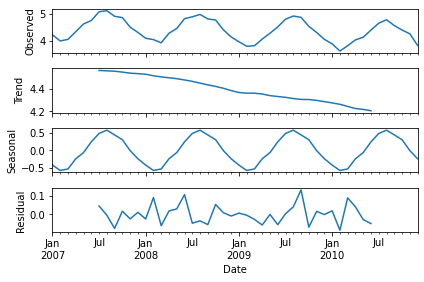

In [ ]:
result.plot() # 1-фактическая составляющая
              # 2-тренд
              # 3-сезонная составляющая
              # 4-ошибки
plt.show()

**42.	Трендовая составляющая содержится в параметре trend. Выведите на экран первые 10 наблюдений.**

In [ ]:
result.trend.head(10)

Date
2007-01-01         NaN
2007-02-01         NaN
2007-03-01         NaN
2007-04-01         NaN
2007-05-01         NaN
2007-06-01         NaN
2007-07-01    4.562917
2007-08-01    4.559583
2007-09-01    4.556250
2007-10-01    4.548333
Name: Value, dtype: float64

**43.	Сезонная составляющая содержится в параметре seasonal. Выведите на экран первые 5 наблюдений.**

In [ ]:
result.seasonal.head()

Date
2007-01-01   -0.414907
2007-02-01   -0.567546
2007-03-01   -0.524630
2007-04-01   -0.236574
2007-05-01   -0.059907
Name: Value, dtype: float64

**44.	Остатки содержатся в параметре resid. Выведите на экран первые 10 наблюдений.**

In [ ]:
result.resid.head(10)

Date
2007-01-01         NaN
2007-02-01         NaN
2007-03-01         NaN
2007-04-01         NaN
2007-05-01         NaN
2007-06-01         NaN
2007-07-01    0.045741
2007-08-01   -0.004259
2007-09-01   -0.076204
2007-10-01    0.017407
Name: Value, dtype: float64

# **ЗАДАНИЕ 6. ПРИМЕНЕНИЕ ФИКТИВНЫХ ПЕРЕМЕННЫХ ДЛЯ МОДЕЛИРОВАНИЯ СЕЗОННЫХ КОЛЕБАНИЙ**

Постройте тренд-сезонную модель, описывающую ряд данных по ценам на материал 2. Для описания сезонных колебаний используйте фиктивные переменные. Рассчитайте показатели точности и адекватности построенной модели. Дайте точечный и интервальный прогнозы на 1 год вперёд по построенной модели.

Постарайтесь максимально автоматизировать все вычисления, использовать существующие модули среды программирования Python.


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from pandas.plotting import autocorrelation_plot
import scipy.stats
import seaborn as sns
from sklearn.linear_model import LinearRegression

**1.	Прочитайте данные по ценам на материал 2 и приведите их к виду, пригодному для дальнейшего анализа (см. пп.1-10 Задания 1).**

In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab_data/data_TS/')

In [ ]:
data=pd.read_excel('data.xls', sheet_name='Material 2')
data.head()

,Unnamed: 0,Unnamed: 1,Рыночные цены на материал 2 (руб.),Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,NaN,NaN,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,...,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00
1,№ организации,1.0,4.22,3.99,4.05,4.34,4.63,4.76,5.09,5.13,...,3.81,4.03,4.13,4.4,4.66,4.79,4.57,4.4,4.26,3.82
2,NaN,2.0,4,4.14,4.43,4.79,5.1,5.17,5.12,4.89,...,4.87,5.19,5.29,5.46,5.45,5.15,4.94,4.6,4.41,4.35
3,NaN,3.0,3.9,3.74,3.9,4.13,4.31,4.66,4.76,4.85,...,4.23,4.48,4.71,5.05,5.21,5.21,5.19,5.08,4.77,4.53
4,NaN,4.0,3.64,3.94,4.09,4.73,5,5.46,5.46,5.41,...,4.23,4.55,5.1,5.41,5.62,5.36,5.05,4.54,4.24,3.83


# **1.ГОТОВИМ ДАННЫЕ ДЛЯ РЕГРЕССИИ**

In [ ]:
df = data.iloc[0:2,2:].T.rename(columns={0: 'Date', 1: 'Value'}).set_index('Date')
df.dtypes
#iloc[0:2,2:]                             - нарезал нужные строки и столбцы
#.T                                       - поверхул всё, т.е. транспонировал
#.rename(columns={0: 'Date', 1: 'Value'}) - поменял названия столбцов
# .set_index('Date')                      - сделал столбец с датами индексом

Value    object
dtype: object

In [ ]:
df['Value'] = df['Value'].astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2007-01-01 to 2010-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [ ]:
df.sample(4)

,Value
Date,
2010-10-01,4.40
2008-09-01,4.82
2010-11-01,4.26
2010-02-01,3.61


**2.	Убедитесь в том, что Вы работаете с объектом Series, а не DataFrame. Превратить таблицу с одним столбцом целевых значений в объект Series можно с помощью функции squeeze(). Дайте ему название series.**

In [ ]:
series=df.squeeze()
type(series)

pandas.core.series.Series

**3.	Посмотрите на динамику временного ряда и его положение относительно линейного тренда визуально с помощью функции regplot(x=x, y=y, data=data) из модуля seaborn. В качестве x возьмите номера наблюдений, а y – значения цены на материал 2. Прокомментируйте результат. Обратите внимание на амплитуду колебаний.**

In [ ]:
y=series.values

In [ ]:
t=np.arange(1,len(y)+1)
t

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

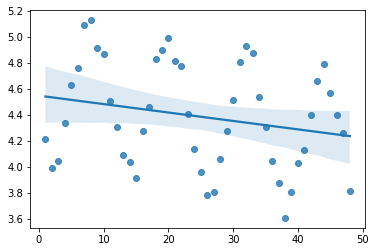

In [ ]:
sns.regplot(x=t, y=y, data= df) # сезонность есть

**4.	Определите лаг сезонности с помощью коррелограммы. Воспользуйтесь функцией autocorrelation_plot() из модуля pandas.plotting. Запишите предполагаемое число.**

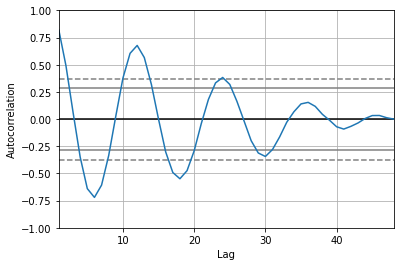

In [ ]:
autocorrelation_plot(y) # лаг сезонности примерно 12 месяцев
plt.show()

**5.	Создайте таблицу данных с названием dataframe, в которой в качестве столбцов представлены месяц ('month'), год ('year'), цена ('price') и номер наблюдения ('t'). При создании столбцов для года и месяца воспользуйтесь соответственно параметрами month и year индекса временного ряда series, встроенных в списковое включение с циклом for.**

Код для столбца month: [series.index[i].month for i in range(len(series))].

Код для столбца year: [series.index[i].year for i in range(len(series))].

Код для столбца price: [series[i] for i in range(len(series))].
Код для столбца t: np.arange(1, len(series) + 1).

Выведите на экран первые 5 наблюдений, воспользовавшись функцией head().


In [ ]:
dataframe=pd.DataFrame()

In [ ]:
# альтернатива задать столбцы с датами !!!!!!!!!!!!!!!!!!!!!!!!!(это для справки, не использовал)
dataframe['month']=series.index.month
dataframe['year']=series.index.year

In [ ]:
dataframe['month']=[series.index[i].month for i in range(len(series))]

In [ ]:
dataframe['year']=[series.index[i].year for i in range(len(series))]

In [ ]:
dataframe['price']=[series[i] for i in range(len(series))]

In [ ]:
dataframe['t']=np.arange(1, len(series) + 1) # номер наблюдения (сквозная нумерация)

In [ ]:
dataframe.head(5)

,month,year,price,t
0,1,2007,4.22,1
1,2,2007,3.99,2
2,3,2007,4.05,3
3,4,2007,4.34,4
4,5,2007,4.63,5


**6.	Установите для столбца 'month' тип данных object, воспользовавшись функцией astype().**

In [ ]:
dataframe.month=dataframe.month.astype(object)

**7.	Создайте фиктивные переменные на основе столбца 'month', применив к таблице dataframe функцию get_dummies() из модуля pandas.**

In [ ]:
dataframe=pd.get_dummies(dataframe)
dataframe.head(10)

,year,price,t,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2007,4.22,1,1,0,0,0,0,0,0,0,0,0,0,0
1,2007,3.99,2,0,1,0,0,0,0,0,0,0,0,0,0
2,2007,4.05,3,0,0,1,0,0,0,0,0,0,0,0,0
3,2007,4.34,4,0,0,0,1,0,0,0,0,0,0,0,0
4,2007,4.63,5,0,0,0,0,1,0,0,0,0,0,0,0
5,2007,4.76,6,0,0,0,0,0,1,0,0,0,0,0,0
6,2007,5.09,7,0,0,0,0,0,0,1,0,0,0,0,0
7,2007,5.13,8,0,0,0,0,0,0,0,1,0,0,0,0
8,2007,4.92,9,0,0,0,0,0,0,0,0,1,0,0,0
9,2007,4.87,10,0,0,0,0,0,0,0,0,0,1,0,0


**8.	Число фиктивных переменных должно быть на 1 меньше, чем число категорий, т.е. должно быть 11 фиктивных переменных. Поэтому удалите столбец 'month_1', воспользовавшись функцией pop(). Выведите на экран первые 5 наблюдений.**

In [ ]:
dataframe.pop('month_1') # первый месяц будет базовым
dataframe.head()

,year,price,t,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2007,4.22,1,0,0,0,0,0,0,0,0,0,0,0
1,2007,3.99,2,1,0,0,0,0,0,0,0,0,0,0
2,2007,4.05,3,0,1,0,0,0,0,0,0,0,0,0
3,2007,4.34,4,0,0,1,0,0,0,0,0,0,0,0
4,2007,4.63,5,0,0,0,1,0,0,0,0,0,0,0


# **2.ТЕПЕРЬ ВСЕ ГОТОВО ДЛЯ ПОСТРОЙКИ РЕГРЕССИИ**

In [ ]:
dataframe.shape

(48, 15)

**9.	Разделите исходные данные на обучающий набор (36 наблюдений) и тестовый набор (12 наблюдений). Для этого создайте переменную array, в которую запишите значения переменных таблицы dataframe, обратившись к параметру values. Затем создайте переменные x_train и y_train, содержащие данные обучающей выборки, а также переменные x_test и y_test с данными тестовой выборки. Выведите на экран объем обучающей и тестовой выборки.**

In [ ]:
array=dataframe.values

In [ ]:
x_train=array[0:36,2:14]

In [ ]:
y_train=array[0:36,1]

In [ ]:
x_test =array[36:48,2:14]

In [ ]:
y_test =array[36:48,1]

**10.	Создайте модель линейной регрессии, воспользовавшись функцией LinearRegression() из модуля sklearn.linear_model. Обучите на обучающей выборке модель линейной регрессии, воспользовавшись функцией fit(). Результат запишите в переменную model.**

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model=LinearRegression().fit(x_train,y_train)

**11.	Выведите на экран свободный член модели линейной регрессии, обратившись к ее параметру intercept_.**

In [ ]:
model.intercept_ # это данные для справки, все уже вшито в model

4.406666666666666

**12.	Выведите на экран коэффициенты при независимых переменных в модели линейной регрессии, обратившись к ее параметру coef_.**

In [ ]:
model.coef_ # это данные для справки, все уже вшито в model

array([-0.01      , -0.18666667, -0.32666667, -0.33      , -0.02      ,
        0.22      ,  0.47666667,  0.71666667,  0.81      ,  0.67666667,
        0.54333333,  0.23333333])

ПОЛУЧИЛИ УРАВНЕНИЕ: **y = 4.4066666 - 0.01 * x - 0.18666667*x2 - ...........**

**13.	Найдите расчетные значения результативного признака по модели линейной регрессии на тестовом наборе, воспользовавшись функцией predict(x_test). Результат запишите в переменную y_pred. Выведите на экран ее содержимое.**

In [ ]:
y_pred=model.predict(x_test) # прагноз для тестовой выборки
y_pred

array([3.85      , 3.7       , 3.68666667, 3.98666667, 4.21666667,
       4.46333333, 4.69333333, 4.77666667, 4.63333333, 4.49      ,
       4.17      , 3.92666667])

**14.	Оцените точность модели на тестовой выборке на основе коэффициента детерминации, воспользовавшись функцией r2_score(y_test, y_pred) из модуля sklearn.metrics. Запишите результат.**

In [ ]:
R2=r2_score(y_test, y_pred) # фсё круто
R2

0.9548399037571721

**15.	Оцените точность модели на тестовой выборке на основе средней квадратичной ошибки (MSE), воспользовавшись функцией mean_squared_error(y_test, y_pred) из модуля sklearn.metrics. Запишите результат.**

In [ ]:
MSE=mean_squared_error(y_test, y_pred)
MSE

0.005874074074074062

**18.	Постройте на всех данных лучшую модель. Если это тренд-сезонная модель, то сделать это надо по аналогии с пп.9-12.**

In [ ]:
x=array[:,2:14]
y=array[:,1]

In [ ]:
model=LinearRegression().fit(x,y)

In [ ]:
model.intercept_

4.394583333333332

In [ ]:
model.coef_

array([-0.01048611, -0.15784722, -0.32736111, -0.276875  ,  0.01361111,
        0.22159722,  0.48458333,  0.73256944,  0.83805556,  0.68604167,
        0.54652778,  0.28201389])

In [ ]:
y_pred=model.predict(x)
y_pred

array([4.22625   , 4.04625   , 4.08625   , 4.36625   , 4.56375   ,
       4.81625   , 5.05375   , 5.14875   , 4.98625   , 4.83625   ,
       4.56125   , 4.26875   , 4.10041667, 3.92041667, 3.96041667,
       4.24041667, 4.43791667, 4.69041667, 4.92791667, 5.02291667,
       4.86041667, 4.71041667, 4.43541667, 4.14291667, 3.97458333,
       3.79458333, 3.83458333, 4.11458333, 4.31208333, 4.56458333,
       4.80208333, 4.89708333, 4.73458333, 4.58458333, 4.30958333,
       4.01708333, 3.84875   , 3.66875   , 3.70875   , 3.98875   ,
       4.18625   , 4.43875   , 4.67625   , 4.77125   , 4.60875   ,
       4.45875   , 4.18375   , 3.89125   ])

**19.	Оцените точность модели для всех данных с помощью следующих показателей: коэффициента детерминации, MAE, MSE, RMSE. Соответствующие функции приведены в задании 4. Прокомментируйте полученные результаты.**

In [ ]:
R2=r2_score(y, y_pred)
R2

0.9815451240154099

In [ ]:
MSE=mean_squared_error(y, y_pred)
MSE

0.002928298611111105

In [ ]:
MAE=mean_absolute_error(y, y_pred)
MAE

0.04401041666666675

In [ ]:
RMSE=sqrt(MSE)
RMSE

0.054113756209591524

**20.	Рассчитайте ошибки модели для всех данных. Поместите столбец ошибок 'Error' в таблицу исходных данных. Выведите на экран первые 5 наблюдений.**

In [ ]:
df['Error']=y-y_pred
df.head()

,Value,Error
Date,,
2007-01-01,4.22,-0.00625
2007-02-01,3.99,-0.05625
2007-03-01,4.05,-0.03625
2007-04-01,4.34,-0.02625
2007-05-01,4.63,0.06625


**21.	Постройте линейный график ошибок, воспользовавшись функциями plot() и show() из модуля matplotlib.pyplot. Прокомментируйте результат.**

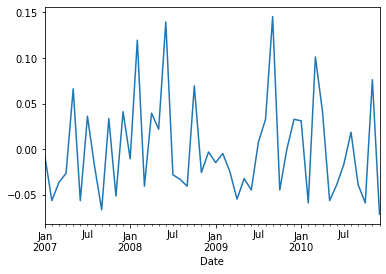

In [ ]:
df.Error.plot()
plt.show()

**22.	Выведите на экран описательные статистики ошибок, воспользовавшись функцией describe(). Прокомментируйте результат.**

In [ ]:
df.Error.describe()

count    4.800000e+01
mean    -7.216450e-16
std      5.468640e-02
min     -7.125000e-02
25%     -4.041667e-02
50%     -1.541667e-02
75%      3.312500e-02
max      1.454167e-01
Name: Error, dtype: float64

**23.	Постройте для ошибок гистограмму на основе функции hist(), ядерную оценку плотности на основе функции plot(kind='kde'), Q-Q график на основе функции qqplot() из модуля statsmodels.graphics.gofplots, а также функцией show() из matplotlib.pyplot. Прокомментируйте результат.**

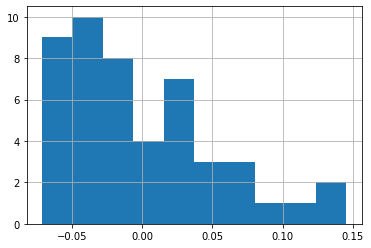

In [ ]:
df.Error.hist()
plt.show()

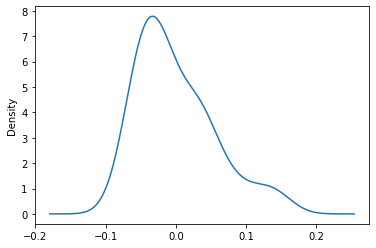

In [ ]:
df.Error.plot(kind='kde')
plt.show()

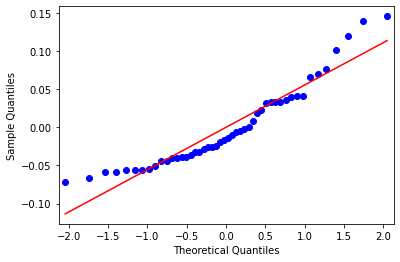

In [ ]:
qqplot(df.Error,line='r')
plt.show()

In [ ]:
d=durbin_watson(df.Error)
d

2.3590442876623046

In [ ]:
4-d

n=48, k=1, alfa=0.05. Для n=50 и k=1, alfa=0.05 dl=1.5, du=1.59.
4-d>du, поэтому гипотеза об отсутствии автокорреляции не отвергается.

**24.	Постройте для ошибок модели коррелограмму, воспользовавшись функцией autocorrelation_plot() из модуля pandas.plotting. Прокомментируйте результат.**

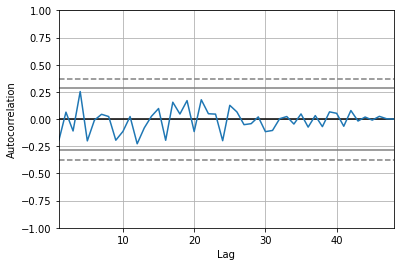

In [ ]:
autocorrelation_plot(df.Error)
plt.show()

**25.	Рассчитайте среднее квадратичное отклонение, воспользовавшись функцией sem() из модуля scipy.stats. Запишите результат в переменную sigma и выведите его на экран.**

In [ ]:
sigma =scipy.stats.sem(y)
sigma

0.058103619380434325

**26.	Рассчитайте двусторонний t критерий Стьюдента для существующего объема выборки и 95% достоверности результата (confidence). Воспользуйтесь функцией t.ppf((1 + confidence) / 2., len(y)-1) из модуля scipy.stats. Запишите результат в переменную tstu и выведите его на экран.**

In [ ]:
confidence=0.95

In [ ]:
tstu=scipy.stats.t.ppf((1 + confidence) / 2., len(y)-1)
tstu

2.0117405104757546

**27.	Сгенерируйте номера наблюдений для прогнозного интервала, равного 12 месяцев, - с 49 по 60 наблюдение. Результат представьте в виде столбца. Для этого воспользуйтесь функцией reshape(-1,1) . Запишите результат в переменную t_new и выведите его на экран.**

In [ ]:
t_new =np.arange(len(y)+1, len(y)+13)
t_new

array([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

In [ ]:
t_new=t_new.reshape(-1,1)
t_new

array([[49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60]])

**28.	Подготовьте значения фиктивных переменных для прогнозного интервала, равного 1 году в помесячной разбивке. Запишите результат в переменную d и выведите его на экран.**

In [ ]:
d=array[0:12,3:14]
d

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

**29.	Создайте на основе переменных t_new и d объекты DataFrame - df_t_new и df_d, воспользовавшись функцией DataFrame() из модуля pandas.**

In [ ]:
df_t_new =pd.DataFrame(t_new)

In [ ]:
df_d=pd.DataFrame(d)

**30.	Объедините их, воспользовавшись функцией concat([df_t_new,df_d],axis=1,names=['t', 'd2','d3','d4','d5','d6','d7','d8','d9','d10','d11','d12']) из модуля pandas. Запишите результат в переменную x_new и выведите его на экран.**

In [ ]:
x_new=pd.concat([df_t_new,df_d],axis=1,names=['t', 'd2','d3','d4','d5','d6','d7','d8','d9','d10','d11','d12'])
x_new

,0,0,1,2,3,4,5,6,7,8,9,10
0,49,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,51,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,52,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,53,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,54,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,55,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**31.	Найдите прогнозные значения цены на материал 2 на год вперед (точечный прогноз), воспользовавшись функцией predict() модели линейной регрессии. Запишите результат в переменную y_new и выведите его на экран.**

In [ ]:
y_new =model.predict(x_new)
y_new

array([3.72291667, 3.54291667, 3.58291667, 3.86291667, 4.06041667,
       4.31291667, 4.55041667, 4.64541667, 4.48291667, 4.33291667,
       4.05791667, 3.76541667])

**32.	Рассчитайте верхнюю границу прогнозного интервала, воспользовавшись формулой: y_up=y_new+tstu*sigma. Выведите результат на экран.**

In [ ]:
y_up=y_new+tstu*sigma
y_up

array([3.83980607, 3.65980607, 3.69980607, 3.97980607, 4.17730607,
       4.42980607, 4.66730607, 4.76230607, 4.59980607, 4.44980607,
       4.17480607, 3.88230607])

**33.	Рассчитайте нижнюю границу прогнозного интервала, воспользовавшись формулой: y_down=y_new-tstu*sigma. Выведите результат на экран.**

In [ ]:
y_down=y_new-tstu*sigma
y_down

array([3.60602726, 3.42602726, 3.46602726, 3.74602726, 3.94352726,
       4.19602726, 4.43352726, 4.52852726, 4.36602726, 4.21602726,
       3.94102726, 3.64852726])

**34.	Нанесите на одну диаграмму фактические значения, значения по модели, точечный и интервальный прогнозы, воспользовавшись функциями figure(), scatter(), plot(), xlabel(), ylabel(), legend() и show() из модуля matplotlib.pyplot.**

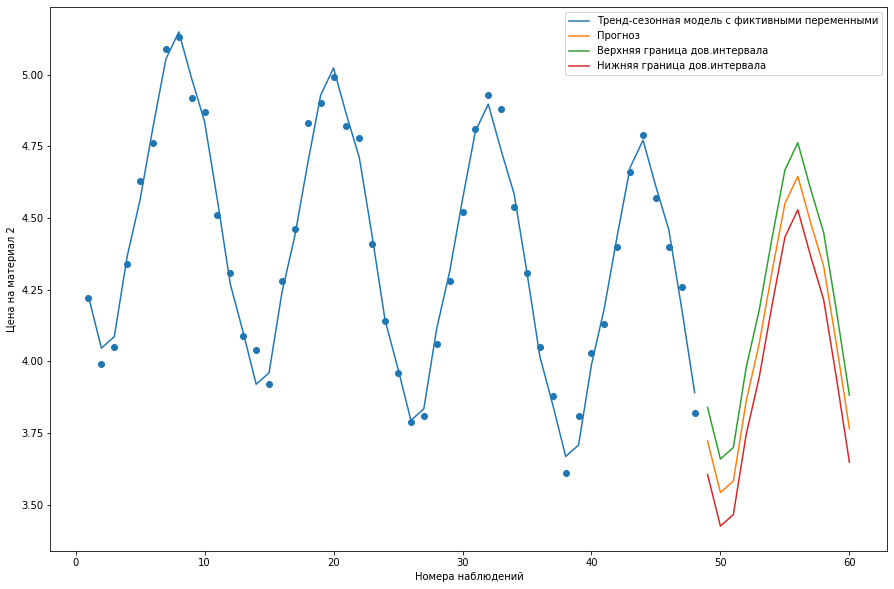

In [ ]:
plt.figure(figsize=(15,10))

plt.scatter(t,y)

plt.plot(t,y_pred)
plt.plot(t_new,y_new)
plt.plot(t_new,y_up)
plt.plot(t_new,y_down)

plt.xlabel('Номера наблюдений')
plt.ylabel('Цена на материал 2')
plt.legend(['Тренд-сезонная модель с фиктивными переменными','Прогноз','Верхняя граница дов.интервала','Нижняя граница дов.интервала'])

plt.show()